In [1]:
import os
import pandas as pd
import tqdm
from tqdm import tqdm_notebook
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import LSTM, Dense
from keras.layers import Dropout, Activation, Flatten
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
df_ge = pd.read_csv( "us.ge.txt", index_col=0)
print(df_ge.head())


              Open    High     Low   Close   Volume  OpenInt
Date                                                        
1962-01-02  0.6277  0.6362  0.6201  0.6201  2575579        0
1962-01-03  0.6201  0.6201  0.6122  0.6201  1764749        0
1962-01-04  0.6201  0.6201  0.6037  0.6122  2194010        0
1962-01-05  0.6122  0.6122  0.5798  0.5957  3255244        0
1962-01-08  0.5957  0.5957  0.5716  0.5957  3696430        0


In [3]:
'''
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()
'''

'\nplt.figure()\nplt.plot(df_ge["Open"])\nplt.plot(df_ge["High"])\nplt.plot(df_ge["Low"])\nplt.plot(df_ge["Close"])\nplt.title(\'GE stock price history\')\nplt.ylabel(\'Price (USD)\')\nplt.xlabel(\'Days\')\nplt.legend([\'Open\',\'High\',\'Low\',\'Close\'], loc=\'upper left\')\nplt.show()\n'

In [4]:
'''
plt.figure()
plt.plot(df_ge["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()
'''

'\nplt.figure()\nplt.plot(df_ge["Volume"])\nplt.title(\'GE stock volume history\')\nplt.ylabel(\'Volume\')\nplt.xlabel(\'Days\')\nplt.show()\n'

In [5]:
print("checking if any null values are present\n", df_ge.isna().sum())

checking if any null values are present
 Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [6]:
#train_cols = ["Open","High","Low","Close","Volume"]
train_cols = ["Open","High","Low","Close"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

Train and Test size 11246 2812


In [7]:
# Loading training data into X
x = df_train.loc[:,train_cols].values
# Min Max scalr normalizing
#min_max_scaler = MinMaxScaler()
# Normalizing Training data
#x_train = min_max_scaler.fit_transform(x)
x_train=x
# Normalizing testing
#x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
x_test = df_test.loc[:,train_cols].values
x_test

array([[27.935, 28.049, 27.769, 28.049],
       [27.814, 28.066, 27.776, 28.003],
       [28.099, 28.178, 27.953, 28.058],
       ...,
       [20.21 , 20.32 , 20.07 , 20.12 ],
       [20.04 , 20.071, 19.85 , 19.99 ],
       [19.98 , 20.68 , 19.9  , 20.49 ]])

In [8]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [9]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [10]:
TIME_STEPS = 18
Y_index = 3
X_Train, Y_Train = build_timeseries(x_train, Y_index,TIME_STEPS)
#x_t = trim_dataset(x_t, BATCH_SIZE)
#y_t = trim_dataset(y_t, BATCH_SIZE)
X_Val, Y_Val = build_timeseries(x_test,  Y_index,TIME_STEPS)
#x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
#y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

/Users/dmitryshribak/.conda/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (11228, 18, 4) (11228,)



length of time-series i/o (2794, 18, 4) (2794,)


In [11]:
Y_Train

array([ 0.5957,  0.5957,  0.6037, ..., 27.382 , 27.718 , 27.912 ])

In [12]:
X_Train.shape

(11228, 18, 4)

In [13]:
# Initialising the RNN
model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(24, return_sequences=True,
               input_shape=(X_Train.shape[1], X_Train.shape[2])))  # returns a sequence of vectors of dimension 64
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(20,activation='relu'))


# Adding the output layer
#model.add(Dense(1, activation="linear"))
model.add(Dense(1))

#model.add(Dense(units = 1))
# Compiling the RNN

model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

history=model.fit(X_Train, Y_Train,
          batch_size=32, epochs=100,
          validation_data=(X_Val, Y_Val))
# Model summary for number of parameters use in the algorithm 
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 11228 samples, validate on 2794 samples
Epoch 1/100





11228/11228 [==============================] - 33s 3ms/step - loss: 24.4201 - acc: 8.9063e-05 - val_loss: 2.7537 - val_acc: 3.5791e-04
Epoch 2/100
11228/11228 [==============================] - 24s 2ms/step - loss: 2.4220 - acc: 0.0000e+00 - val_loss: 0.8102 - val_acc: 0.0000e+00
Epoch 3/100
11228/11228 [==============================] - 24s 2ms/step - loss: 1.7904 - acc: 0.0000e+00 - val_loss: 2.4410 - val_acc: 0.0000e+00
Epoch 4/100
11228/11228 [==============================] - 23s 2ms/step - loss: 1.6900 - acc: 0.0000e+00 - val_loss: 0.4765 - val_acc: 7.1582e-04
Epoch 5/100
11228/11228 [==============================] - 23s 2ms/step - loss: 1.4556 - acc: 0.0000e+00 - val_loss: 0.3025 - val_acc: 7.1582e-0

11228/11228 [==============================] - 22s 2ms/step - loss: 0.2782 - acc: 8.9063e-05 - val_loss: 0.6309 - val_acc: 3.5791e-04
Epoch 88/100
11228/11228 [==============================] - 22s 2ms/step - loss: 0.2852 - acc: 8.9063e-05 - val_loss: 0.3393 - val_acc: 7.1582e-04
Epoch 89/100
11228/11228 [==============================] - 22s 2ms/step - loss: 0.2602 - acc: 8.9063e-05 - val_loss: 0.2724 - val_acc: 0.0014
Epoch 90/100
11228/11228 [==============================] - 22s 2ms/step - loss: 0.2618 - acc: 8.9063e-05 - val_loss: 0.2249 - val_acc: 0.0011
Epoch 91/100
11228/11228 [==============================] - 22s 2ms/step - loss: 0.2723 - acc: 8.9063e-05 - val_loss: 0.2290 - val_acc: 7.1582e-04
Epoch 92/100
11228/11228 [==============================] - 22s 2ms/step - loss: 0.2602 - acc: 0.0000e+00 - val_loss: 0.4012 - val_acc: 3.5791e-04
Epoch 93/100
11228/11228 [==============================] - 21s 2ms/step - loss: 0.2783 - acc: 8.9063e-05 - val_loss: 0.3108 - val_acc: 7.1

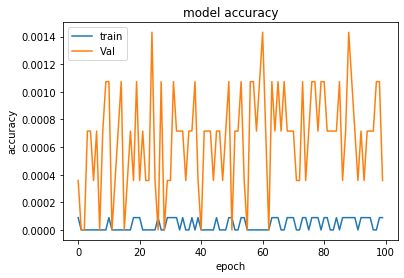

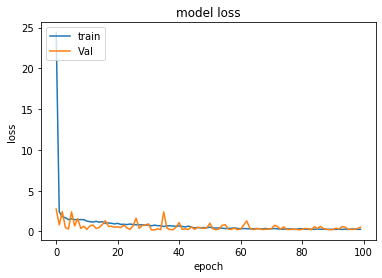

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()


In [39]:
model.save('my_model_01.hdf5')

In [66]:
#print(model.predict(X_Val)
'''
x_buffer = np.zeros((1,TIME_STEPS,4))
for i in range(X_Val.shape[0]):
    x_buffer[0,:,:] = X_Val[i,:,:]
    print(model.predict( x_buffer), Y_Val[i])
'''

'\nx_buffer = np.zeros((1,TIME_STEPS,4))\nfor i in range(X_Val.shape[0]):\n    x_buffer[0,:,:] = X_Val[i,:,:]\n    print(model.predict( x_buffer), Y_Val[i])\n'

In [16]:
predict = model.predict(X_Val)
predict

array([[28.431843],
       [28.404356],
       [28.560135],
       ...,
       [19.35654 ],
       [19.362839],
       [19.172773]], dtype=float32)

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

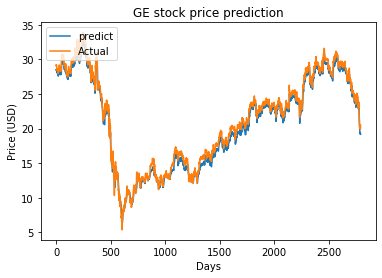

In [17]:
plt.figure()
plt.plot(predict)
plt.plot(Y_Val)

plt.title('GE stock price prediction')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['predict','Actual'], loc='upper left')

plt.savefig("figure.jpg")
plt.show()